In [ ]:
!pip install -q transformers datasets accelerate

In [32]:
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [33]:
df = pd.read_csv(
    "/kaggle/input/preprocessed-dataset/preprocessed_symptom_disease_dataset.csv"
)

df.head()

,symptoms,disease,symptoms_clean
0,i have been experiencing a skin rash on my arm...,psoriasis,i have been experiencing a skin rash on my arm...
1,"my skin has been peeling, especially on my kne...",psoriasis,"my skin has been peeling, especially on my kne..."
2,i have been experiencing joint pain in my fing...,psoriasis,i have been experiencing joint pain in my fing...
3,"there is a silver like dusting on my skin, esp...",psoriasis,"there is a silver like dusting on my skin, esp..."
4,"my nails have small dents or pits in them, and...",psoriasis,"my nails have small dents or pits in them, and..."


In [34]:
# Encode labels 
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["disease"])

num_labels = df["label_id"].nunique()
print("Number of labels:", num_labels)

Number of labels: 24


In [35]:
# Train/Test split 
X_train, X_test, y_train, y_test = train_test_split(
    df["symptoms_clean"],
    df["label_id"],
    test_size=0.2,
    random_state=42,
    stratify=df["label_id"]
)


In [36]:
# Load DistilBERT tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased"
)

In [37]:
# Tokenize the text

def tokenize_text(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=64
    )

train_encodings = tokenize_text(X_train)
test_encodings = tokenize_text(X_test)

In [38]:
# Build PyTorch dataset

class SymptomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [39]:
train_dataset = SymptomDataset(train_encodings, y_train)
test_dataset = SymptomDataset(test_encodings, y_test)

In [40]:
# Load DistilBERT model

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Handle class imbalance

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

In [46]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss(
            weight=class_weights.to(logits.device)
        )
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [49]:
# Training configuration

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=50,
    report_to="none"
)

In [44]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions)
    }


In [50]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


Step,Training Loss,Validation Loss


TrainOutput(global_step=400, training_loss=1.014942193031311, metrics={'train_runtime': 22.2957, 'train_samples_per_second': 285.257, 'train_steps_per_second': 17.941, 'total_flos': 105352899747840.0, 'train_loss': 1.014942193031311, 'epoch': 4.0})

In [51]:
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
))


                                 precision    recall  f1-score   support

                           acne       1.00      1.00      1.00         9
                        allergy       0.89      0.94      0.92        18
                      arthritis       1.00      1.00      1.00        17
               bronchial asthma       1.00      0.89      0.94        18
           cervical spondylosis       1.00      1.00      1.00        17
                    chicken pox       0.94      0.83      0.88        18
                    common cold       0.89      0.94      0.91        17
                         dengue       1.00      0.82      0.90        17
                       diabetes       0.89      0.89      0.89        18
          dimorphic hemorrhoids       1.00      1.00      1.00         8
                  drug reaction       0.89      0.89      0.89        18
               fungal infection       1.00      1.00      1.00        17
gastroesophageal reflux disease       1.00      0.

After four training epochs, the DistilBERT model achieved an accuracy of 96% on the test set.  
Performance was consistent across all disease classes, including those with fewer samples, indicating effective handling of class imbalance.  
Slightly lower recall for symptomatically similar diseases suggests realistic classification behavior rather than overfitting.


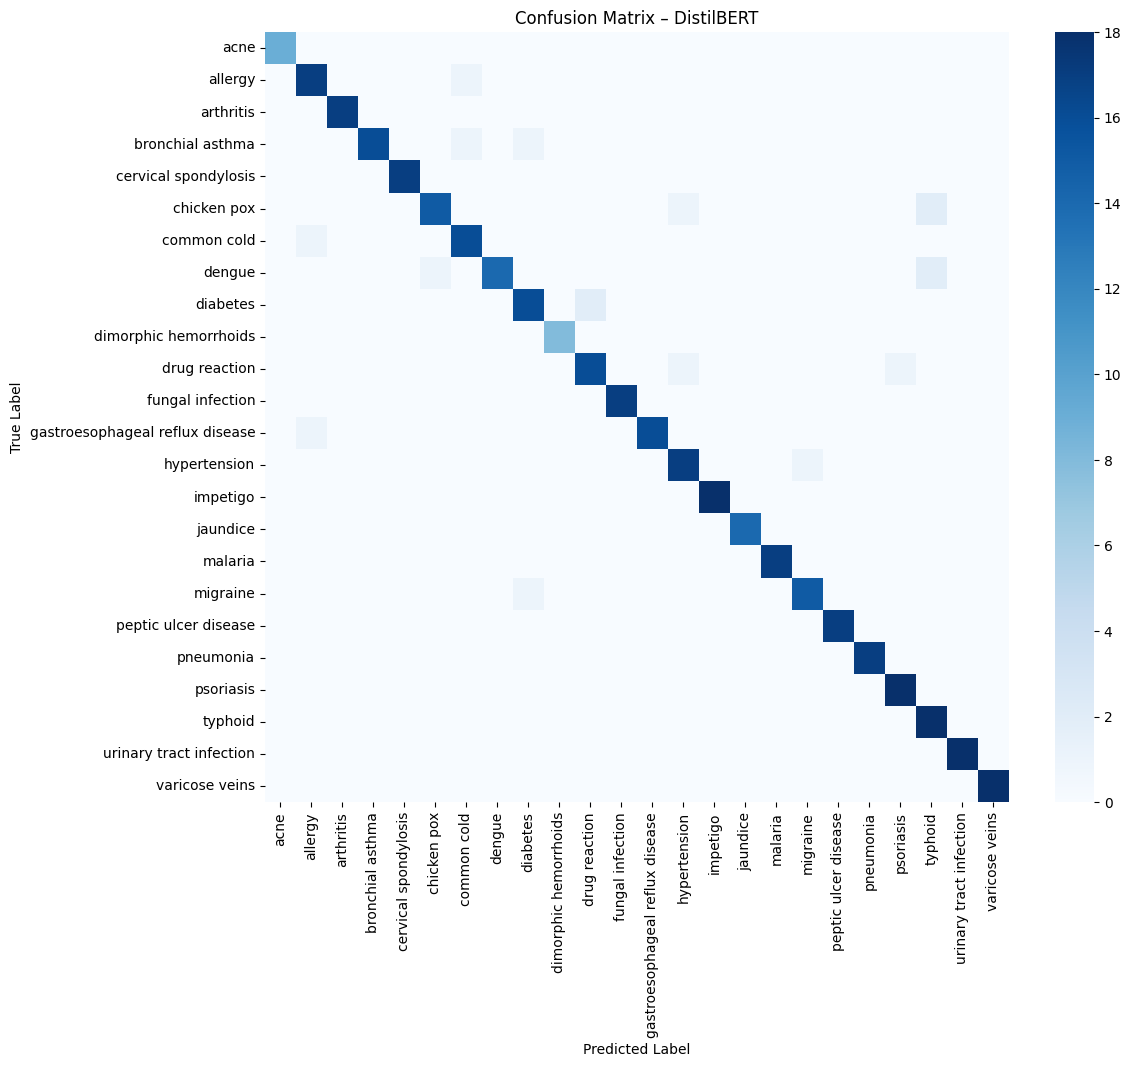

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    fmt="d"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – DistilBERT")
plt.show()

In [53]:
import numpy as np

logits = predictions.predictions
true_labels = y_test.to_numpy()

top3_preds = np.argsort(logits, axis=1)[:, -3:]

top3_correct = [
    true_labels[i] in top3_preds[i]
    for i in range(len(true_labels))
]

top3_accuracy = np.mean(top3_correct)
print("Top-3 Accuracy:", top3_accuracy)


Top-3 Accuracy: 0.9949748743718593


In [54]:
errors = X_test.reset_index(drop=True).to_frame(name="symptoms")
errors["true_disease"] = label_encoder.inverse_transform(y_test)
errors["predicted_disease"] = label_encoder.inverse_transform(y_pred)

misclassified = errors[
    errors["true_disease"] != errors["predicted_disease"]
]

misclassified.head(10)


,symptoms,true_disease,predicted_disease
6,"i have been feeling lightheaded and dizzy, and...",hypertension,migraine
29,i regularly wake up with a scratchy voice or a...,gastroesophageal reflux disease,allergy
33,i have been feeling nauseous and have a consta...,dengue,typhoid
113,i've been feeling really tired and weak. i can...,chicken pox,hypertension
133,i have a rash on my chest and back and it itch...,drug reaction,psoriasis
145,the itching is making it hard for me to sleep ...,chicken pox,typhoid
163,i've been having trouble breathing lately. i'v...,bronchial asthma,common cold
167,"i have a stiff neck and eye issues, and i've b...",migraine,diabetes
326,"i've been having trouble swallowing, and my th...",allergy,common cold
327,i have a runny nose and a sore throat. i've be...,common cold,allergy


In [55]:
for i, row in misclassified.head(5).iterrows():
    print("Symptoms:", row["symptoms"])
    print("True:", row["true_disease"])
    print("Predicted:", row["predicted_disease"])
    print("-" * 60)

Symptoms: i have been feeling lightheaded and dizzy, and i have also noticed that i have been getting headaches more frequently.
True: hypertension
Predicted: migraine
------------------------------------------------------------
Symptoms: i regularly wake up with a scratchy voice or a sore throat. my throat is constantly irritated, and i have horrible breath. i frequently throw up.
True: gastroesophageal reflux disease
Predicted: allergy
------------------------------------------------------------
Symptoms: i have been feeling nauseous and have a constant urge to vomit, which is accompanied with mild fever and headache. i also feel very weak and tired.
True: dengue
Predicted: typhoid
------------------------------------------------------------
Symptoms: i've been feeling really tired and weak. i can barely get out of bed in the morning, and i'm having trouble staying awake during the day.
True: chicken pox
Predicted: hypertension
--------------------------------------------------------